<a href="https://colab.research.google.com/github/roldanjrgl/ml_project/blob/main/notebooks/cifar_vit_load_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
# testing change and committing form google colab 
# commit from notebook saved on drive

In [ ]:
# Transformations, same as the ViT training scripts if without autoaug policy
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [ ]:
# Load train set
train_set = dsets.CIFAR10('../data', train=True, download=True, transform=transform_train)

# Load test set (using as validation)
val_set = dsets.CIFAR10('../data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


# train vit model on cifar-10

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os.path
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

In [ ]:
from copy import deepcopy

In [ ]:
# Select device
device = torch.device('cuda:0')

### training of the original model (ViT but lighter) is handled by the scripts in directory ViT-CIFAR

we just need to load the model here

In [ ]:
from vit import ViT

In [ ]:
model_path = 'cifar_c10_vit.pt'

In [ ]:
if os.path.isfile(model_path):
    # load saved model
    print("Loading saved model")
    model = torch.load(model_path).to(device)
else:
    # Create model from trained
    print("Creating model, from elsewhere pretrained")
    model = ViT(in_c = 3, num_classes=10, img_size=32, patch=8, dropout=0.0, num_layers=7,
           hidden=384, mlp_hidden=384, head=12, is_cls_token=True)
    loaded = torch.load("../ViT-CIFAR/weights/vit_c10_aa_ls_note_oriforFastSHAP.pth")
    model_states = {key[6:]:loaded[key] for key in loaded}
    model.load_state_dict(model_states)
    model = model.to(device)

Loading saved model


SAME as the resnet model, ViT model outputs unnormalized logits (scores) for each class, which serve as inputs to the Cross Entropy Loss

In [ ]:
torch.save(model.cpu(), model_path)

# train surrogates

In [ ]:
from fastshap import ImageSurrogate
from fastshap.utils import MaskLayer2d, DatasetInputOnly, KLDivLoss

In [ ]:
surr_model_path = 'cifar_c10_vit_surrogate_lb20.pt'

In [ ]:
# Check for model
if os.path.isfile(surr_model_path):
    print('Loading saved surrogate model')
    surr = torch.load(surr_model_path).to(device)
    surrogate = ImageSurrogate(surr, width=32, height=32, superpixel_size=2)
else:
    print("Creating new surrogate model")
    surr = nn.Sequential(
        MaskLayer2d(value=0, append=True),
        ViT(in_c = 4, num_classes=10, img_size=32, patch=8, dropout=0.0, num_layers=7,
        hidden=384, mlp_hidden=384, head=12, is_cls_token=True)).to(device)
    # Set up surrogate object
    surrogate = ImageSurrogate(surr, width=32, height=32, superpixel_size=2)

Loading saved surrogate model


In [ ]:
# to retrain just go from here 
# print("Creating new surrogate model")
# surr = nn.Sequential(
#     MaskLayer2d(value=0, append=True),
#     ViT(in_c = 4, num_classes=10, img_size=32, patch=8, dropout=0.0, num_layers=7,
#     hidden=384, mlp_hidden=384, head=12, is_cls_token=True)).to(device)
# # Set up surrogate object
# surrogate = ImageSurrogate(surr, width=32, height=32, superpixel_size=2)

In [ ]:
# Set up datasets
train_surr = DatasetInputOnly(train_set)
val_surr = DatasetInputOnly(val_set)
original_model = nn.Sequential(model, nn.Softmax(dim=1)).to(device)

In [ ]:
# Train
surrogate.train_original_model(
    train_surr,
    val_surr,
    original_model,
    batch_size=256,
    max_epochs=100,
    loss_fn=KLDivLoss(),
    lookback=20, #10
    bar=True,
    verbose=True)

Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 1 -----
Val loss = 1.6505

New best epoch, loss = 1.6505



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 2 -----
Val loss = 1.4880

New best epoch, loss = 1.4880



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 3 -----
Val loss = 1.3444

New best epoch, loss = 1.3444



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 4 -----
Val loss = 1.2947

New best epoch, loss = 1.2947



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 5 -----
Val loss = 1.2671

New best epoch, loss = 1.2671



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 6 -----
Val loss = 1.1874

New best epoch, loss = 1.1874



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 7 -----
Val loss = 1.1752

New best epoch, loss = 1.1752



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 8 -----
Val loss = 1.1351

New best epoch, loss = 1.1351



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 9 -----
Val loss = 1.1042

New best epoch, loss = 1.1042



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 10 -----
Val loss = 1.0675

New best epoch, loss = 1.0675



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 11 -----
Val loss = 1.0382

New best epoch, loss = 1.0382



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 12 -----
Val loss = 1.0431



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 13 -----
Val loss = 1.0055

New best epoch, loss = 1.0055



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 14 -----
Val loss = 0.9852

New best epoch, loss = 0.9852



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 15 -----
Val loss = 1.0188



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 16 -----
Val loss = 0.9484

New best epoch, loss = 0.9484



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 17 -----
Val loss = 0.9447

New best epoch, loss = 0.9447



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 18 -----
Val loss = 0.9204

New best epoch, loss = 0.9204



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 19 -----
Val loss = 0.9370



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 20 -----
Val loss = 0.8849

New best epoch, loss = 0.8849



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 21 -----
Val loss = 0.8934



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 22 -----
Val loss = 0.8837

New best epoch, loss = 0.8837



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 23 -----
Val loss = 0.8584

New best epoch, loss = 0.8584



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 24 -----
Val loss = 0.8644



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 25 -----
Val loss = 0.8517

New best epoch, loss = 0.8517



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 26 -----
Val loss = 0.8533



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 27 -----
Val loss = 0.8407

New best epoch, loss = 0.8407



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 28 -----
Val loss = 0.8375

New best epoch, loss = 0.8375



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 29 -----
Val loss = 0.8287

New best epoch, loss = 0.8287



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 30 -----
Val loss = 0.8730



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 31 -----
Val loss = 0.8398



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 32 -----
Val loss = 0.8487



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 33 -----
Val loss = 0.8271

New best epoch, loss = 0.8271



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 34 -----
Val loss = 0.8619



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 35 -----
Val loss = 0.8509



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 36 -----
Val loss = 0.8478



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 37 -----
Val loss = 0.8525



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 38 -----
Val loss = 0.8579



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 39 -----
Val loss = 0.8859



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 40 -----
Val loss = 0.8685



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 41 -----
Val loss = 0.8813



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 42 -----
Val loss = 0.8642



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 43 -----
Val loss = 0.9159



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 44 -----
Val loss = 0.8859

Epoch    44: reducing learning rate of group 0 to 5.0000e-04.


Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 45 -----
Val loss = 0.9024



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 46 -----
Val loss = 0.8969



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 47 -----
Val loss = 0.9275



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 48 -----
Val loss = 0.9186



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 49 -----
Val loss = 0.9053



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 50 -----
Val loss = 0.9272



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 51 -----
Val loss = 0.9628



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 52 -----
Val loss = 0.9712



Training epoch:   0%|          | 0/196 [00:00<?, ?it/s]

----- Epoch = 53 -----
Val loss = 0.9617

Stopping early


In [ ]:
surr.cpu()
# torch.save(surr, 'cifar_c10_vit_surrogate_lb20.pt') # lookback 20, best val loss 0.7623
torch.save(surr, surr_model_path) # lookback 20, best val loss, best vak kiss 0.5698
# ls 0.827

# train fastshap

In [ ]:
from unet import UNet
from fastshap import FastSHAP

In [ ]:
explainer_path = 'cifar_explainer_unet_lb20.pt'

In [ ]:
# Check for model
if os.path.isfile(explainer_path):
    print('Loading saved explainer model')
    explainer = torch.load(explainer_path).to(device)
    fastshap = FastSHAP(explainer, surrogate, link=nn.LogSoftmax(dim=1))

else:
    # Set up explainer model
    explainer = UNet(n_classes=10, num_down=2, num_up=1, num_convs=3).to(device)

    # Set up FastSHAP object
    fastshap = FastSHAP(explainer, surrogate, link=nn.LogSoftmax(dim=1))

    # Set up datasets
    fastshap_train = DatasetInputOnly(train_set)
    fastshap_val = DatasetInputOnly(val_set)

    # Train
    fastshap.train(
        fastshap_train,
        fastshap_val,
        batch_size=128,
        num_samples=2,
        max_epochs=200,
        eff_lambda=1e-2,
        validation_samples=1,
        lookback=10,
        bar=True,
        verbose=True)
    
    # Save explainer
    explainer.cpu()
    torch.save(explainer, explainer_path)
    explainer.to(device)

Loading saved explainer model


# visualization

In [ ]:
import matplotlib.pyplot as plt

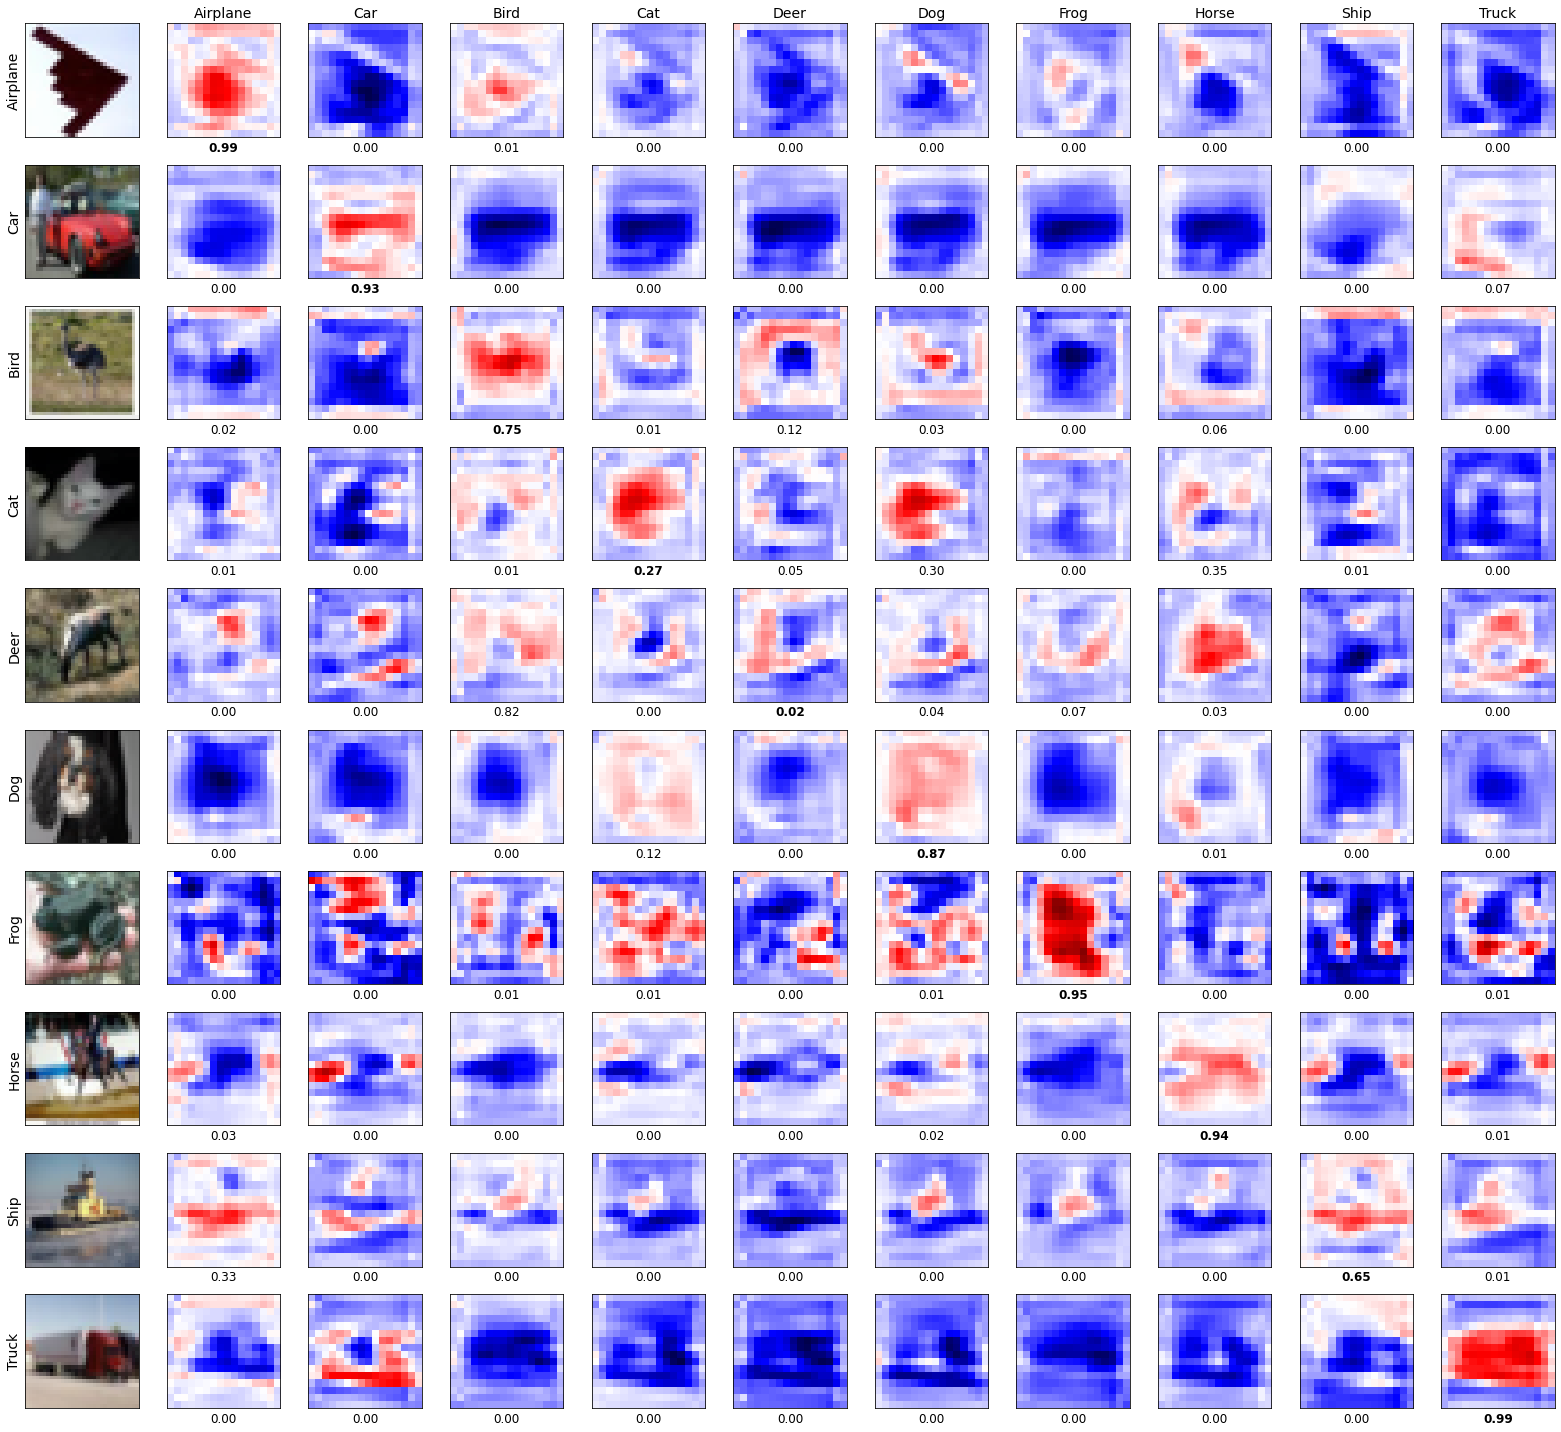

In [ ]:
# Select one image from each class
dset = val_set
targets = np.array(dset.targets)
num_classes = targets.max() + 1
inds_lists = [np.where(targets == cat)[0] for cat in range(num_classes)]
inds = [np.random.choice(cat_inds) for cat_inds in inds_lists]
x, y = zip(*[dset[ind] for ind in inds])
x = torch.stack(x)

# Get explanations
values = fastshap.shap_values(x.to(device))

# Get predictions
pred = surrogate(
    x.to(device),
    torch.ones(num_classes, surrogate.num_players, device=device)
).softmax(dim=1).cpu().data.numpy()

fig, axarr = plt.subplots(num_classes, num_classes + 1, figsize=(22, 20))

for row in range(num_classes):
    # Image
    classes = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
    mean = np.array([0.4914, 0.4822, 0.4465])[:, np.newaxis, np.newaxis]
    std = np.array([0.2023, 0.1994, 0.2010])[:, np.newaxis, np.newaxis]
    im = x[row].numpy() * std + mean
    im = im.transpose(1, 2, 0).astype(float)
    im = np.clip(im, a_min=0, a_max=1)
    axarr[row, 0].imshow(im, vmin=0, vmax=1)
    axarr[row, 0].set_xticks([])
    axarr[row, 0].set_yticks([])
    axarr[row, 0].set_ylabel('{}'.format(classes[y[row]]), fontsize=14)
    
    # Explanations
    m = np.abs(values[row]).max()
    for col in range(num_classes):
        axarr[row, col + 1].imshow(values[row, col], cmap='seismic', vmin=-m, vmax=m)
        axarr[row, col + 1].set_xticks([])
        axarr[row, col + 1].set_yticks([])
        if col == y[row]:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12, fontweight='bold')
        else:
            axarr[row, col + 1].set_xlabel('{:.2f}'.format(pred[row, col]), fontsize=12)
        
        # Class labels
        if row == 0:
            axarr[row, col + 1].set_title('{}'.format(classes[y[col]]), fontsize=14)

plt.tight_layout()
plt.show()